In [37]:
# Import packages
from preprocessing.filtering import Preprocess
from preprocessing.fiducials import FpCollection
from preprocessing import PPG

from preprocessing import Fiducials, Biomarkers
import pyPPG.biomarkers as BM

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from pathlib import Path
from dotmap import DotMap
import numpy as np
import pandas as pd
import scipy.io
import random
import os
import h5py

In [38]:
data_path = "dataset/data/S001_128.mat" # the path of the file containing the PPG signal to be analysed
start_sig = 0 # the first sample of the signal to be analysed
end_sig = -1 # the last sample of the signal to be analysed (here a value of '-1' indicates the last sample)
savingfolder = 'temp_dir'
savingformat = 'csv'

# Load raw PPG signal
# signal = load_data(data_path=data_path, start_sig=start_sig, end_sig=end_sig, use_tk=False)

In [802]:
class OneSignal:
    def __init__(self, data_name = None):
        """
        :param
            --data_name: filename like 'S001_128.mat' or tuple (data_path,label_path,peaks_path)
        """
        super().__init__()
        parent = 'dataset'
        child = ["data", "label", "peaks"]
        if not isinstance(data_name,tuple):
            self.data_path = os.path.join(parent, child[0], data_name)
            self.label_path = os.path.join(parent, child[1], data_name)
            self.peaks_path = os.path.join(parent, child[2], data_name)
            self.name = data_name
        else:
            self.data_path = data_name[0]
            self.label_path = data_name[1]
            self.peaks_path = data_name[2]
            self.name = data_name[0].split('.')[0][-8:]

        self.raw = scipy.io.loadmat(self.data_path)['ppg']
        self.fs = int(self.data_path.split('.')[0][-3:])
        self.ppg = "call .filter() to calculate"
        self.vpg = "call .filter() to calculate"
        self.jpg = "call .filter() to calculate"
        self.apg = "call .filter() to calculate"
        # self.on = "call .filter() to calculate"
        self.peaks = scipy.io.loadmat(self.peaks_path)['speaks']
        self.labels = scipy.io.loadmat(self.label_path)['labels']

        self.v = np.squeeze(self.raw)
        correction = pd.DataFrame()
        corr_on = ['on', 'dn', 'dp', 'v', 'w', 'f']
        correction.loc[0, corr_on] = True
        self.correction = correction

        # Prepare onset alignment with provided peaks (from fiducials)
        self.indx = 0 # peak to crop
        self.indx_max = int(self.peaks.shape[0])

    def filter(self, fL=0.8, fH=3.3, order=4, sm = {'ppg':50,'vpg':10,'apg':10,'jpg':10}, data_min= -90, data_max= 90):

        print(f'filtering signal {self.name}...')
        # Class which the functions need...
        s = DotMap()
        s.end_sig = -1
        s.v = np.squeeze(self.raw)
        s.fs = self.fs
        s.filtering = True
        s.name = self.name
        corr_on = ['on', 'dn', 'dp', 'v', 'w', 'f']
        correction = pd.DataFrame()
        correction.loc[0, corr_on] = True
        s.correct = correction

        # Filters signal through BP filter [fL,fH]
        prep = Preprocess(fL=fL, fH=fH, order=order, sm_wins=sm)
        s.ppg, s.vpg, s.apg, s.jpg = prep.get_signals(s=s)
        self.ppg = s.ppg
        self.vpg = s.vpg
        self.apg = s.apg
        self.jpg = s.jpg

        self.s = PPG(s)

    def get_fiducials(self):
        # Initialize fiducials package
        fpex = FpCollection(s=self.s)
        # Extract fiducial points (e.g. 'on': peak onsets)
        fiducials = fpex.get_fiducials(s=self.s, ext_peaks=self.peaks)
        # Create a fiducials class
        self.fp = Fiducials(fiducials)

    def get_biomarkers(self):
        # Initialize biomarkers package
        bmex = BM.BmCollection(s=self.s, fp=self.fp)
        # Extract biomarkers
        bm_defs, bm_vals, bm_stats = bmex.get_biomarkers()

        # tmp_keys=bm_stats.keys()
        # print('Statistics of the biomarkers:')
        # for i in tmp_keys: print(i,'\n',bm_stats[i])

        # Create a biomarkers class
        self.bm = Biomarkers(bm_defs, bm_vals, bm_stats)

    # def align_onsets(self):
    #     # Prepare onset alignment with provided peaks (from fiducials)
    #     self.on = list(self.fp.get_fp().on) # here i'm wasting a lot more points (and time for calculating them...)

    #     # Former add_onsets() method
    #     k = 0
    #     o = []
    #     for i in range(len(self.on) - 1):
    #         o.append(self.on[i])
    #         o2 = self.on[i + 1]
    #         p = self.peaks[k]
    #         p2 = self.peaks[k + 1]
    #         p3 = self.peaks[k + 2]
    #         k += 1
    #         # Scenario where less onsets detected than needed for provided peaks
    #         if p2 < o2:
    #             o.append(int((p + p2) // 2))
    #             k += 1
    #             if p3 < o2:
    #                 o.append(int((p3 + p2) // 2))
    #                 k += 1
    #         # Last peak scenario
    #         if i == (len(self.on) - 2):
    #             o.append(o2)
    #     #
    #     if o[-1] < self.peaks[-3]:
    #         o.append(int((self.peaks[-4] + self.peaks[-3]) // 2))
    #     if o[-1] < self.peaks[-2]:
    #         o.append(int((self.peaks[-3]+self.peaks[-2]) // 2))
    #     if o[-1] < self.peaks[-1]:
    #         o.append(int((self.peaks[-2] + self.peaks[-1]) // 2))
    #     o.append(int(len(self.ppg)-1))

    #     # Filter out multiple onsets in between peaks
    #     i = 0
    #     j = 0
    #     result_onsets = []

    #     # Check and append onset before the first peak
    #     if o[j] < self.peaks[0]:
    #         result_onsets.append(o[j])
    #         j += 1
    #     else:
    #         # If the first onset is already after the first peak, append 0 as the starting point
    #         result_onsets.append(0)

    #     while i < len(self.peaks) - 1 and j < len(o):
    #         if o[j] < self.peaks[i + 1]:
    #             # If there's a second onset and it's closer to the next peak than the first onset
    #             if j + 1 < len(o) and o[j + 1] < self.peaks[i + 1] and self.peaks[i + 1] - o[j + 1] < self.peaks[i + 1] - o[j]:
    #                 print('skipped: ', o[j])
    #                 j += 1
    #                 continue
    #             result_onsets.append(o[j])
    #             j += 1
    #         else:
    #             i += 1

    #     result_onsets.extend(o[j:])

    #     self.on = np.array(result_onsets, dtype=int)
    def align_onsets(self):
        # Prepare onset alignment with provided peaks (from fiducials)
        self.on = list(self.fp.get_fp().on) # here i'm wasting a lot more points (and time for calculating them...)

        k = 0
        o = []
        for i in range(len(self.on) - 1):
            o.append(self.on[i])
            o2 = self.on[i + 1]
            p = self.peaks[k]
            p2 = self.peaks[k + 1]
            p3 = self.peaks[k + 2]
            k += 1
            # Scenario where less onsets detected than needed for provided peaks
            if p2 < o2:
                o.append(int((p + p2) // 2))
                k += 1
                if p3 < o2:
                    o.append(int((p3 + p2) // 2))
                    k += 1
            # Last peak scenario
            if i == (len(self.on) - 2):
                o.append(o2)
        #
        if o[-1] < self.peaks[-3]:
            o.append(int((self.peaks[-4] + self.peaks[-3]) // 2))
        if o[-1] < self.peaks[-2]:
            o.append(int((self.peaks[-3]+self.peaks[-2]) // 2))
        if o[-1] < self.peaks[-1]:
            o.append(int((self.peaks[-2] + self.peaks[-1]) // 2))
        o.append(int(len(self.ppg)-1))

        self.on = np.array(o, dtype=int)

#         self.on = list(fiducials['on'][:]) # here i'm wasting a lot more points (and time for calculating them...)

#         self.add_onsets()

#         self.normalize(data_min, data_max)

#     def get_crops(self):

#         crops = []
#         labs = []
#         while (self.indx < self.indx_max):
#             x, y = self.crop()
#             crops.append(x)
#             labs.append(y)
#         return (crops,labs)

#     def normalize(self, data_min, data_max):
#         new = self.ppg.reshape(-1, 1)
#         scaler = MinMaxScaler()

#         scaler.data_min_ = data_min
#         scaler.data_max_ = data_max

#         self.ppg = scaler.fit_transform(new)

#     def add_onsets(self):
#         k = 0
#         o = []
#         for i in range(len(self.on) - 1):
#             o.append(self.on[i])
#             o2 = self.on[i + 1]
#             p = self.peaks[k]
#             p2 = self.peaks[k + 1]
#             p3 = self.peaks[k + 2]
#             k += 1
#             # Scenario where less onsets detected than needed for provided peaks
#             if p2 < o2:
#                 o.append(int((p + p2) // 2))
#                 k += 1
#                 if p3 < o2:
#                     o.append(int((p3 + p2) // 2))
#                     k += 1
#             # Last peak scenario
#             if i == (len(self.on) - 2):
#                 o.append(o2)
#         #
#         if o[-1] < self.peaks[-3]:
#             o.append(int((self.peaks[-4] + self.peaks[-3]) // 2))
#         if o[-1] < self.peaks[-2]:
#             o.append(int((self.peaks[-3]+self.peaks[-2]) // 2))
#         if o[-1] < self.peaks[-1]:
#             o.append(int((self.peaks[-2] + self.peaks[-1]) // 2))
#         o.append(int(len(self.ppg)-1))

#         self.on = np.array(o, dtype=int)


#     def crop(self):

#         crop = self.ppg[self.on[self.indx]:self.on[self.indx+1]]
#         lab = self.labels[self.indx]
#         self.indx+=1
#         return (crop,lab)

# ---------------------------------------------------------------------------------------------------------------------
# class Crops():
#     def __init__(self, N="N_crops.h5", V="V_crops.h5", S="S_crops.h5", parent=Path('dataset/crops'), seed=36):
#         super().__init__()
#         names_list = [N,V,S]
#         for names in names_list:
#             print(f"loading {names}...")
#             with h5py.File(parent / names, 'r') as file:
#                 name = Path(names).stem
#                 setattr(self, name, [file[key][:] for key in file.keys() if key != 'labels'])
#                 setattr(self, f"{name[0]}_labels", list(file['labels'][:].astype('U')))

#         self.seed = seed

#     def split(self, test_size=.15):

#         x = self.V_crops + self.S_crops + self.N_crops
#         y = self.V_labels + self.S_labels + self.N_labels

#         x_train_val, x_test, y_train_val, y_test = train_test_split(x, y, random_state=self.seed, test_size=test_size,
#                                                                     shuffle=True, stratify=y)
#         x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, random_state=self.seed, test_size=len(x_test),
#                                                                     shuffle=True, stratify=y_train_val)
#         setattr(self,'train', [(x, y) for x, y in zip(x_train, y_train)])
#         setattr(self,'val', [(x, y) for x, y in zip(x_val, y_val)])
#         setattr(self,'test', [(x, y) for x, y in zip(x_test, y_test)])



In [803]:
data_name = "S001_128.mat"
S001_128 = OneSignal(data_name)

C:\Users\robbe\AppData\Local\Temp\ipykernel_4948\3870041150.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  correction.loc[0, corr_on] = True


In [804]:
S001_128.filter()

filtering signal S001_128.mat...


C:\Users\robbe\AppData\Local\Temp\ipykernel_4948\3870041150.py:53: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  correction.loc[0, corr_on] = True
c:\Users\robbe\OneDrive - UGent\UGent\Ma2\Methods & Applications of AI in Biomedicine [I.C.]\Applied AI in Biomedicine (Corino Valentina)\AI_PPG\preprocessing\__init__.py:62: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  correction.loc[0, corr_on] = True


In [805]:
S001_128.get_fiducials()

In [575]:
S001_128.get_biomarkers()

c:\Users\robbe\OneDrive - UGent\UGent\Ma2\Methods & Applications of AI in Biomedicine [I.C.]\Applied AI in Biomedicine (Corino Valentina)\AI_PPG\pyPPG\ppg_bm\bm_extraction.py:1288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_biomarkers.loc[i] = lst
c:\Users\robbe\OneDrive - UGent\UGent\Ma2\Methods & Applications of AI in Biomedicine [I.C.]\Applied AI in Biomedicine (Corino Valentina)\AI_PPG\pyPPG\ppg_bm\bm_extraction.py:1288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_biomarkers.loc[i

no more peaks


c:\Users\robbe\OneDrive - UGent\UGent\Ma2\Methods & Applications of AI in Biomedicine [I.C.]\Applied AI in Biomedicine (Corino Valentina)\AI_PPG\pyPPG\ppg_bm\bm_extraction.py:1288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_biomarkers.loc[i] = lst
c:\Users\robbe\OneDrive - UGent\UGent\Ma2\Methods & Applications of AI in Biomedicine [I.C.]\Applied AI in Biomedicine (Corino Valentina)\AI_PPG\pyPPG\ppg_bm\bm_extraction.py:1288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_biomarkers.loc[i

no more peaks


c:\Users\robbe\OneDrive - UGent\UGent\Ma2\Methods & Applications of AI in Biomedicine [I.C.]\Applied AI in Biomedicine (Corino Valentina)\AI_PPG\pyPPG\ppg_bm\bm_extraction.py:1288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_biomarkers.loc[i] = lst
c:\Users\robbe\OneDrive - UGent\UGent\Ma2\Methods & Applications of AI in Biomedicine [I.C.]\Applied AI in Biomedicine (Corino Valentina)\AI_PPG\pyPPG\ppg_bm\bm_extraction.py:1288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_biomarkers.loc[i

no more peaks
no more peaks


In [806]:
print(S001_128.fp.get_fp())

                    on      sp      dn      dp     off       u       v     w  \
Index of pulse                                                                 
0                    0      83     112    <NA>     128      64      82  <NA>   
1                  128     165     195    <NA>     210     148     180  <NA>   
2                  210     247     277    <NA>     294     230     263  <NA>   
3                  294     330     355    <NA>     365     315     338  <NA>   
4                  365     394     444    <NA>     453     380     416  <NA>   
...                ...     ...     ...     ...     ...     ...     ...   ...   
2502            229672  229722  229737    <NA>  229748  229697  229720  <NA>   
2503            229748  229811  229828    <NA>  229844  229774  229809  <NA>   
2504            229844  229896  229935    <NA>  229953  229887  229913  <NA>   
2505            229953  229984  230000    <NA>  230001  229970  229982  <NA>   
2506            230001  230050  230070  

In [807]:
print(dir(S001_128.bm))

AttributeError: 'OneSignal' object has no attribute 'bm'

In [ ]:
print(dir(S001_128.bm.get_bm()))

AttributeError: 'OneSignal' object has no attribute 'bm'

In [ ]:
print(S001_128.bm.get_bm().index)

AttributeError: 'OneSignal' object has no attribute 'bm'

In [ ]:
S001_128.bm.get_bm().bm_vals.ppg_sig.TimeStamp

AttributeError: 'OneSignal' object has no attribute 'bm'

In [808]:
S001_128.align_onsets()

C:\Users\robbe\AppData\Local\Temp\ipykernel_4948\3870041150.py:163: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  o.append(int((p + p2) // 2))
C:\Users\robbe\AppData\Local\Temp\ipykernel_4948\3870041150.py:166: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  o.append(int((p3 + p2) // 2))
C:\Users\robbe\AppData\Local\Temp\ipykernel_4948\3870041150.py:175: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  o.append(int((self.peaks[-3]+self.peaks[-2]) // 2))
C:\Users\robbe\A

In [809]:
S001_128.on

array([     0,    128,    210, ..., 230017, 230103, 230387])

In [810]:
S001_128.fp.get_fp()[1000:1010]

,on,sp,dn,dp,off,u,v,w,a,b,c,d,e,f,p1,p2
Index of pulse,,,,,,,,,,,,,,,,
1000,89924,89978,89989,90045,90094,89998,90034,<NA>,89979,90008,<NA>,<NA>,89979,<NA>,90014,<NA>
1001,90094,90147,90158,90165,90196,90114,90144,90164,90097,90128,90140,90140,90154,90174,90140,90162
1002,90196,90226,90249,<NA>,90259,90213,90235,<NA>,90199,90226,90242,90242,90255,90254,90242,90259
1003,90259,90316,90327,90349,90438,90272,90301,90333,90258,90284,90300,90300,90316,90348,90300,90328
1004,90438,90484,90491,90508,90536,90452,90481,90492,90437,90464,90467,90467,90490,90492,90466,90467
1005,90536,90566,90601,<NA>,90626,90559,90592,<NA>,90544,90577,90595,90595,90603,90621,90589,90595
1006,90626,90650,90689,<NA>,90699,90654,90672,<NA>,90642,90669,90684,90684,90697,90696,90684,90699
1007,90699,90733,90751,90763,90786,90712,90738,90762,90698,90724,90737,90737,90748,90770,90734,90737
1008,90786,90816,90843,<NA>,90858,90802,90831,<NA>,90790,90816,90828,90828,90856,90855,90828,90858


In [811]:
S001_128.peaks.shape

(2603, 1)

In [812]:
# Check for correct onset alignment with peaks:
print(f"""1) onset at index i occurs before the peak  at index i+1: {np.all(S001_128.on[:-1] < S001_128.peaks.flatten())}""")
if not np.all(S001_128.on[:-1] < S001_128.peaks.flatten()):
    print(f"   --> incorrect at index: {np.where((S001_128.on[:-1] < S001_128.peaks.flatten()) == 0)[0]}")
print(f"""2) peak  at index i occurs before the onset at index i+1: {np.all(S001_128.peaks.flatten() < S001_128.on[1:])}""")
if not np.all(S001_128.peaks.flatten() < S001_128.on[1:]):
    print(f"   --> incorrect at index: {np.where((S001_128.peaks.flatten() < S001_128.on[1:]) == 0)[0]}")

ValueError: operands could not be broadcast together with shapes (2604,) (2603,) 

In [813]:
np.where((S001_128.peaks.flatten() < S001_128.on)==1),\
np.all((S001_128.peaks.flatten() < S001_128.on)==1)

ValueError: operands could not be broadcast together with shapes (2603,) (2605,) 

In [698]:
S001_128.peaks.flatten()[1004:1008], S001_128.on[1004:1009]

(array([100038, 100137, 100236, 100335]),
 array([100013, 100186, 100285, 100412, 100498]))

In [699]:
a, b = S001_128.peaks.flatten()[-3:], S001_128.on[-5:]
a, b = S001_128.peaks.flatten(), S001_128.on

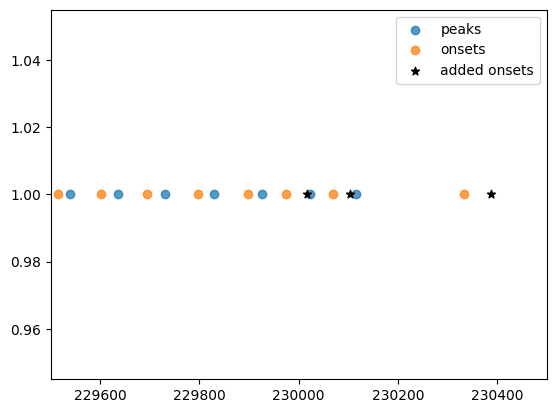

In [815]:
import matplotlib.pyplot as plt

added_onsets = [e for e in S001_128.on if e not in list(S001_128.fp.get_fp().on)]

plt.scatter(a, np.ones(len(a)), label='peaks', alpha=0.75)
plt.scatter(b, np.ones(len(b)), label='onsets', alpha=0.75)
plt.scatter(added_onsets, np.ones(len(added_onsets)), label='added onsets', marker='*', alpha=1, color='k')
plt.legend()

plt.xlim([229500, 230500])
# plt.xlim([11000, 12000])
# plt.xlim([0, 1000])
# plt.xlim([100000, 101000])
plt.show()

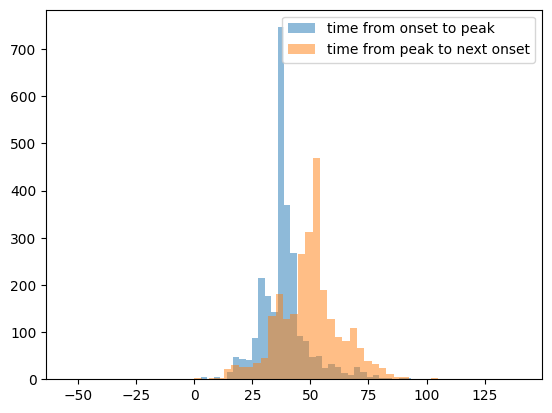

In [216]:
plt.hist(S001_128.peaks.flatten() - S001_128.on[:-(n_on-n_peaks)], bins=50, alpha=0.5, label='time from onset to peak')
plt.hist(S001_128.on[1:-(n_on-n_peaks)+1] - S001_128.peaks.flatten(), bins=50, alpha=0.5, label='time from peak to next onset')
plt.legend()
plt.show()

In [201]:
S001_128.fp.get_fp().on.shape

(2507,)

In [202]:
# Number of onsets added which were not in fiducials:
len([e for e in S001_128.on if e not in list(S001_128.fp.get_fp().on)])

98

In [226]:
# Number of fiducials which were not used for the final onset list:
len([e for e in list(S001_128.fp.get_fp().on) if e not in S001_128.on])

0

In [223]:
(S001_128.peaks.flatten() - S001_128.on[:-(n_on-n_peaks)]).std()

10.666553047738331

In [224]:
(S001_128.on[1:-(n_on-n_peaks)+1] - S001_128.peaks.flatten()).std()

13.640112929364664

## NEW WAY of ALIGNING ONSETS

In [987]:
class OneSignal:
    def __init__(self, data_name = None):
        """
        :param
            --data_name: filename like 'S001_128.mat' or tuple (data_path,label_path,peaks_path)
        """
        super().__init__()
        parent = 'dataset'
        child = ["data", "label", "peaks"]
        if not isinstance(data_name,tuple):
            self.data_path = os.path.join(parent, child[0], data_name)
            self.label_path = os.path.join(parent, child[1], data_name)
            self.peaks_path = os.path.join(parent, child[2], data_name)
            self.name = data_name
        else:
            self.data_path = data_name[0]
            self.label_path = data_name[1]
            self.peaks_path = data_name[2]
            self.name = data_name[0].split('.')[0][-8:]

        self.raw = scipy.io.loadmat(self.data_path)['ppg']
        self.fs = int(self.data_path.split('.')[0][-3:])
        self.ppg = "call .filter() to calculate"
        self.vpg = "call .filter() to calculate"
        self.jpg = "call .filter() to calculate"
        self.apg = "call .filter() to calculate"
        # self.on = "call .filter() to calculate"
        self.peaks = scipy.io.loadmat(self.peaks_path)['speaks']
        self.labels = scipy.io.loadmat(self.label_path)['labels']

        self.v = np.squeeze(self.raw)
        correction = pd.DataFrame()
        corr_on = ['on', 'dn', 'dp', 'v', 'w', 'f']
        correction.loc[0, corr_on] = True
        self.correction = correction

        # Prepare onset alignment with provided peaks (from fiducials)
        self.indx = 0 # peak to crop
        self.indx_max = int(self.peaks.shape[0])

    def filter(self, fL=0.8, fH=3.3, order=4, sm = {'ppg':50,'vpg':10,'apg':10,'jpg':10}, data_min= -90, data_max= 90):

        print(f'filtering signal {self.name}...')
        # Class which the functions need...
        s = DotMap()
        s.end_sig = -1
        s.v = np.squeeze(self.raw)
        s.fs = self.fs
        s.filtering = True
        s.name = self.name
        corr_on = ['on', 'dn', 'dp', 'v', 'w', 'f']
        correction = pd.DataFrame()
        correction.loc[0, corr_on] = True
        s.correct = correction

        # Filters signal through BP filter [fL,fH]
        prep = Preprocess(fL=fL, fH=fH, order=order, sm_wins=sm)
        s.ppg, s.vpg, s.apg, s.jpg = prep.get_signals(s=s)
        self.ppg = s.ppg
        self.vpg = s.vpg
        self.apg = s.apg
        self.jpg = s.jpg

        self.s = PPG(s)

    def get_fiducials(self):
        # Initialize fiducials package
        fpex = FpCollection(s=self.s)
        # Extract fiducial points (e.g. 'on': peak onsets)
        fiducials = fpex.get_fiducials(s=self.s, ext_peaks=self.peaks)
        # Create a fiducials class
        self.fp = Fiducials(fiducials)

    def get_biomarkers(self):
        # Initialize biomarkers package
        bmex = BM.BmCollection(s=self.s, fp=self.fp)
        # Extract biomarkers
        bm_defs, bm_vals, bm_stats = bmex.get_biomarkers()

        # tmp_keys=bm_stats.keys()
        # print('Statistics of the biomarkers:')
        # for i in tmp_keys: print(i,'\n',bm_stats[i])

        # Create a biomarkers class
        self.bm = Biomarkers(bm_defs, bm_vals, bm_stats)

    def align_onsets(self):
        # Prepare onset alignment with provided peaks (from fiducials)
        self.get_fiducials()
        onsets, peaks = list(self.fp.get_fp().on).copy(), list(self.peaks.flatten())
        
        # Always include the first onset in the filtered list
        # If no onset detected before first peak
        if onsets[0] >= peaks[0]:
            print('No onset detected before first peak')
            filtered_onsets = [0]
            # Remaining onsets to be considered: all of them
            remaining_onsets = onsets
        else:
            onsets_before_first_peak = [onset for onset in onsets if onset < peaks[0]]
            filtered_onsets = [onsets_before_first_peak[-1]]
            # Remaining onsets to be considered: 
            remaining_onsets = onsets[len(onsets_before_first_peak):]
        
        # Iterate through peaks to determine the closest onset for each peak
        for i in range(len(peaks) - 1):
            # Current and next peaks
            peak = peaks[i]
            next_peak = peaks[i + 1]

            # Find the onsets that lie between the current and next peak
            possible_onsets = [onset for onset in remaining_onsets if (peak < onset) and (onset < next_peak)]

            if not possible_onsets:
                # If no onset is detected between two peaks, add one in the middle
                middle_onset = int((peak + next_peak) / 2)
                filtered_onsets.append(middle_onset)
                # print('onset added at: ', middle_onset)
            else:
                # Find the onset that minimizes the distance to the next peak
                closest_onset = min(possible_onsets, key=lambda x: abs(x - next_peak))
                # Include the closest onset in the filtered list
                filtered_onsets.append(closest_onset)
                # Remove the chosen onset from the remaining onsets
                remaining_onsets = [onset for onset in remaining_onsets if (onset not in possible_onsets) and (onset > next_peak)]
                # if len(possible_onsets) >= 2:
                #     print('multiple onsets between peaks: ', possible_onsets)

        # Include the last onset in the filtered list
        if remaining_onsets:
            print('remaining onsets: ', remaining_onsets)
            filtered_onsets.append(remaining_onsets[-1])
        else:
            print('added end of signal')
            filtered_onsets.append(int(len(self.ppg)-1))
        
        self.on = np.array(filtered_onsets, dtype=int)
    
    def crop(self):
        crop = self.ppg[self.on[self.indx]:self.on[self.indx+1]]
        lab = self.labels[self.indx]
        self.indx+=1
        return (crop, lab)

class Crops():
    def __init__(self, N="N_crops.h5", V="V_crops.h5", S="S_crops.h5", parent=Path('dataset/crops'), seed=36):
        super().__init__()
        names_list = [N,V,S]
        for names in names_list:
            print(f"loading {names}...")
            with h5py.File(parent / names, 'r') as file:
                name = Path(names).stem
                setattr(self, name, [file[key][:] for key in file.keys() if key != 'labels'])
                setattr(self, f"{name[0]}_labels", list(file['labels'][:].astype('U')))

        self.seed = seed

    def split(self, test_size=.15):
        x = self.V_crops + self.S_crops + self.N_crops
        y = self.V_labels + self.S_labels + self.N_labels

        x_train_val, x_test, y_train_val, y_test = train_test_split(x, y, random_state=self.seed, test_size=test_size,
                                                                    shuffle=True, stratify=y)
        x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, random_state=self.seed, test_size=len(x_test),
                                                                    shuffle=True, stratify=y_train_val)
        setattr(self,'train', [(x, y) for x, y in zip(x_train, y_train)])
        setattr(self,'val', [(x, y) for x, y in zip(x_val, y_val)])
        setattr(self,'test', [(x, y) for x, y in zip(x_test, y_test)])

In [988]:
data_name = "S050_128.mat"
S001_128 = OneSignal(data_name)

C:\Users\robbe\AppData\Local\Temp\ipykernel_4948\313786618.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  correction.loc[0, corr_on] = True


In [990]:
S001_128.filter()

filtering signal S050_128.mat...


C:\Users\robbe\AppData\Local\Temp\ipykernel_4948\313786618.py:53: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  correction.loc[0, corr_on] = True
c:\Users\robbe\OneDrive - UGent\UGent\Ma2\Methods & Applications of AI in Biomedicine [I.C.]\Applied AI in Biomedicine (Corino Valentina)\AI_PPG\preprocessing\__init__.py:62: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  correction.loc[0, corr_on] = True


In [991]:
# S001_128.get_fiducials()

In [992]:
S001_128.align_onsets()

added end of signal


In [993]:
print(S001_128.on.shape)

(2384,)


In [994]:
S001_128.peaks.shape

(2383, 1)

In [995]:
# Check for correct onset alignment with peaks:
n_peaks = len(S001_128.peaks.flatten())
n_on = len(S001_128.on)
print(f"""1) onset at index i occurs before the peak  at index i+1: {np.all(S001_128.on[:-(n_on-n_peaks)] < S001_128.peaks.flatten())}""")
if not np.all(S001_128.on[:-(n_on-n_peaks)] < S001_128.peaks.flatten()):
    print(f"   --> incorrect at index: {np.where(np.all(S001_128.on[:-(n_on-n_peaks)] < S001_128.peaks.flatten()) == 0)}")
print(f"""2) peak  at index i occurs before the onset at index i+1: {np.all(S001_128.peaks.flatten() < S001_128.on[1:])}""")
if not np.all(S001_128.peaks.flatten() < S001_128.on[1:]):
    print(f"   --> incorrect at index: {np.where((S001_128.peaks.flatten() < S001_128.on[1:]) == 0)[0]}")

1) onset at index i occurs before the peak  at index i+1: True
2) peak  at index i occurs before the onset at index i+1: True


In [982]:
# np.all(S001_128.peaks.flatten() < np.concatenate([S001_128.on[1:-3], S001_128.on[-2:]]))
np.all(S001_128.peaks.flatten() < S001_128.on[1:])

True

In [983]:
np.where((S001_128.on[:-1] < S001_128.peaks.flatten()) == 0)

(array([], dtype=int64),)

In [984]:
np.where((S001_128.peaks.flatten() < S001_128.on[1:]) == 0)

(array([], dtype=int64),)

In [971]:
print(S001_128.on[-10:])

[229625 229687 229734 229838 229917 229983 230051 230130 230199 230434]


In [972]:
a, b = S001_128.peaks.flatten()[-3:], S001_128.on[-5:]
a, b = S001_128.peaks.flatten(), S001_128.on

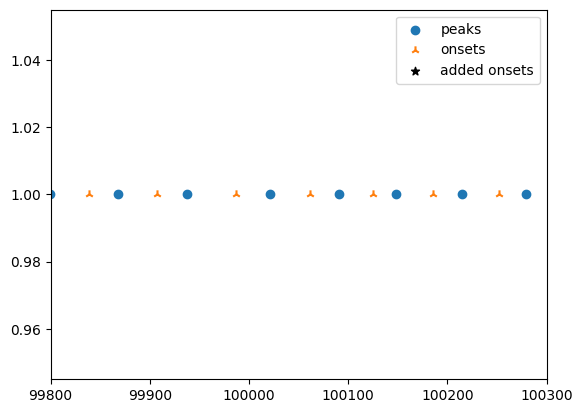

In [973]:
import matplotlib.pyplot as plt

added_onsets = [e for e in S001_128.on if e not in list(S001_128.fp.get_fp().on)]

plt.scatter(a, np.ones(len(a)), label='peaks')
plt.scatter(b, np.ones(len(b)), label='onsets', marker='2')
plt.scatter(added_onsets, np.ones(len(added_onsets)), label='added onsets', marker='*', alpha=1, color='k')
plt.legend()

plt.xlim([229500, 230500])
plt.xlim([11000, 12000])
plt.xlim([99800, 100300])
plt.show()

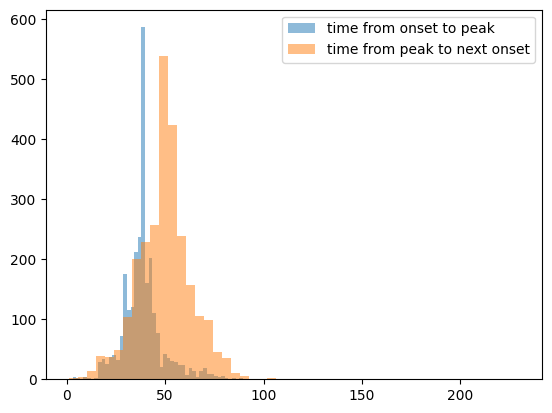

In [938]:
plt.hist(S001_128.peaks.flatten() - S001_128.on[:-1], bins=50, alpha=0.5, label='time from onset to peak')
plt.hist(S001_128.on[1:] - S001_128.peaks.flatten(), bins=50, alpha=0.5, label='time from peak to next onset')
plt.legend()
plt.show()

In [ ]:
S001_128.fp.get_fp().on.shape

(2507,)

In [ ]:
# Number of onsets added which were not in fiducials:
len([e for e in S001_128.on if e not in list(S001_128.fp.get_fp().on)])

98

In [ ]:
# Number of fiducials which were not used for the final onset list:
len([e for e in list(S001_128.fp.get_fp().on) if e not in S001_128.on])

0

In [955]:
(S001_128.peaks.flatten() - S001_128.on[:-1]).mean()

48.20496894409938

In [956]:
(S001_128.on[1:] - S001_128.peaks.flatten()).mean()

70.99482401656314

In [960]:
S001_128.fs

128

In [737]:
def filter_onsets(onsets, peaks):
    filtered_onsets = [onsets[0]]  # Always include the first onset
    remaining_onsets = onsets[1:]

    for peak in peaks:
        closest_onset = min(remaining_onsets, key=lambda x: abs(x - peak))
        remaining_onsets.remove(closest_onset)
        filtered_onsets.append(closest_onset)

    return filtered_onsets

# Example usage:
onsets = [1, 3, 5.5, 6, 8, 10]
peaks = [2, 5, 7, 9]

result = filter_onsets(onsets, peaks)
print(result)

[1, 3, 5.5, 6, 8]


In [738]:
def filter_onsets(onsets, peaks):
    filtered_onsets = [onsets[0]]  # Always include the first onset
    remaining_onsets = onsets[1:]

    for peak in peaks:
        closest_onset = min(remaining_onsets, key=lambda x: abs(x - peak))
        remaining_onsets = [onset for onset in remaining_onsets if onset != closest_onset]
        filtered_onsets.append(closest_onset)

    return filtered_onsets

# Example usage:
onsets = [1, 3, 5.5, 6, 8, 10]
peaks = [2, 5, 7, 9]

result = filter_onsets(onsets, peaks)
print(result)

[1, 3, 5.5, 6, 8]


In [751]:
def filter_onsets(onsets, peaks):
    # Always include the first onset in the filtered list
    filtered_onsets = [onsets[0]]
    # Remaining onsets to be considered
    remaining_onsets = onsets[1:]

    # Iterate through peaks to determine the closest onset for each peak
    for i in range(len(peaks) - 1):
        # Current and next peaks
        peak = peaks[i]
        next_peak = peaks[i + 1]

        # Find the onsets that lie between the current and next peak
        possible_onsets = [onset for onset in remaining_onsets if (peak < onset) and (onset < next_peak)]
        # Find the onset that minimizes the distance to the next peak
        closest_onset = min(possible_onsets, key=lambda x: abs(x - next_peak))
        # Include the closest onset in the filtered list
        filtered_onsets.append(closest_onset)
        # Remove the chosen onset from the remaining onsets
        remaining_onsets = [onset for onset in remaining_onsets if onset not in possible_onsets]

    # Include the last onset in the filtered list
    filtered_onsets.append(onsets[-1])

    return filtered_onsets

# Example usage:
onsets = [1, 3, 5.5, 6, 8, 10]
peaks = [2, 5, 7, 9]

result = filter_onsets(onsets, peaks)
print(result)

[1, 3, 6, 8, 10]
